In [94]:
import pandas as pd
import numpy as np
import networkx as nx
import sys
from matplotlib.colors import to_rgba
import matplotlib.pyplot as plt
# adding Folder_2/subfolder to the system path
sys.path.insert(0, '/work/ccnr/glover.co/net_design/NetDesign')
import network_design as nd
import netrd

In [63]:
data = np.loadtxt('../../data/pollinator_network/M_PL_074_12.csv',delimiter=',')

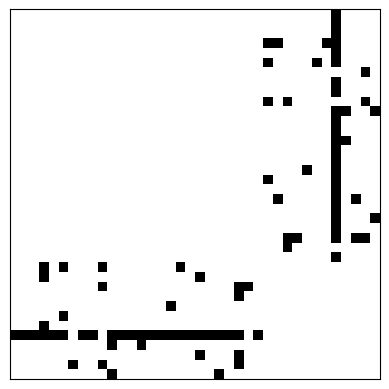

In [133]:
plt.imshow(O,cmap='binary')
plt.xticks([],[])
plt.yticks([],[])
plt.savefig('pollinator_O.pdf')
plt.show()

In [64]:
A = np.zeros((data.shape[0]+data.shape[1],data.shape[0]+data.shape[1]))

In [65]:
A[:data.shape[0],-data.shape[1]:] = data
A[data.shape[0]:,:-data.shape[1]] = data.T

In [66]:
g = nx.from_numpy_array(A)

In [71]:
pollinator = nd.NetAssembly(X,O,X.sum(axis=0,dtype=int))
pollinator.g = g
pollinator.draw(with_networkx=False,output='pollinator_network.pdf')

<Figure size 500x500 with 0 Axes>

In [72]:
X = np.eye(g.number_of_nodes())

In [73]:
new_X = np.tile(X,(5,1))

In [74]:
O = nd.extract_O(g,X)

In [113]:
test = nd.NetAssembly(new_X,O,new_X.sum(axis=0,dtype=int),system_energy=1)

In [114]:
test.run(100000,link_strength=1,component=False)

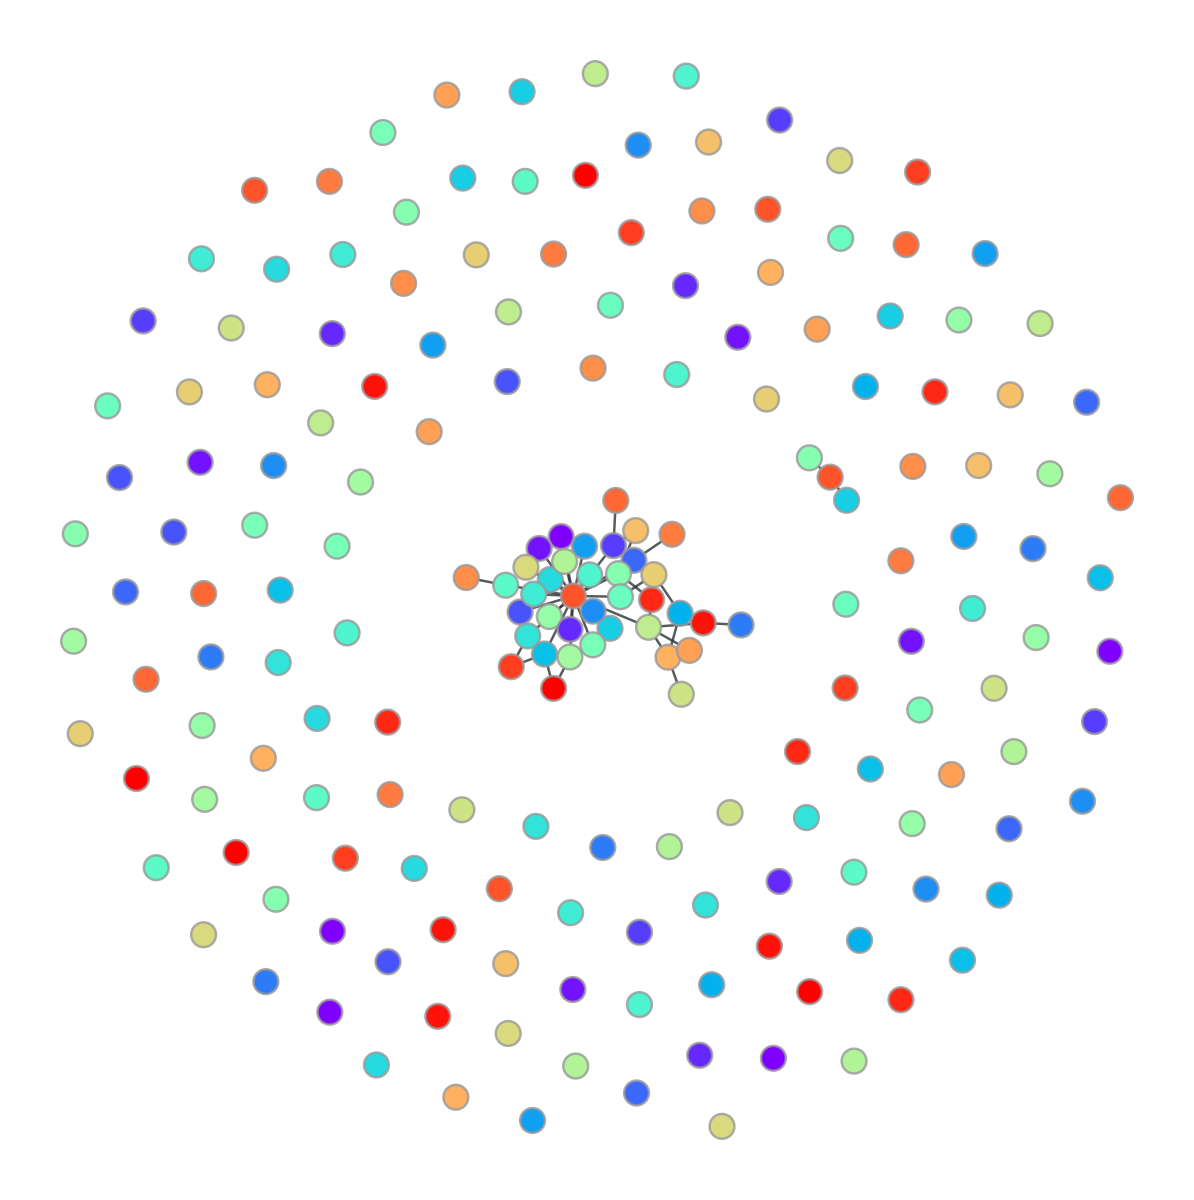

<Figure size 500x500 with 0 Axes>

In [126]:
test.draw(with_networkx=False)

In [116]:
target_network = g
for i in range(4):
    target_network = nx.disjoint_union(g,target_network)

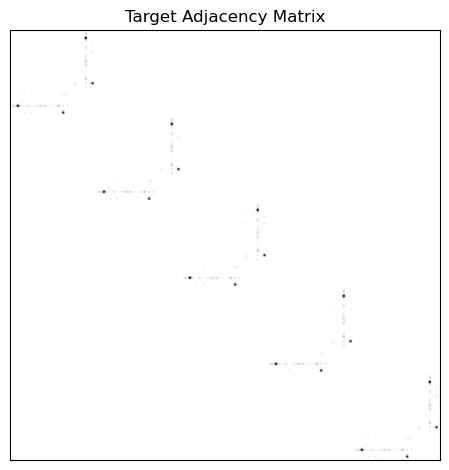

In [117]:
target_A = nx.adjacency_matrix(target_network).toarray()
plt.imshow(target_A,cmap='binary')
plt.xticks([],[])
plt.yticks([],[])
plt.title('Target Adjacency Matrix')
plt.tight_layout()
plt.savefig('pollinator_target_adjacency_matrix.pdf')
plt.show()

In [118]:
components = [c for c in nx.connected_components(test.g)]
components = sorted(components,key=len,reverse=True)
order = []
for c in components:
    order += list(c)
complex0_A = nx.adjacency_matrix(test.g).toarray()
complex0_A = complex0_A[order,:][:,order]
complex0_g = nx.from_numpy_array(complex0_A)

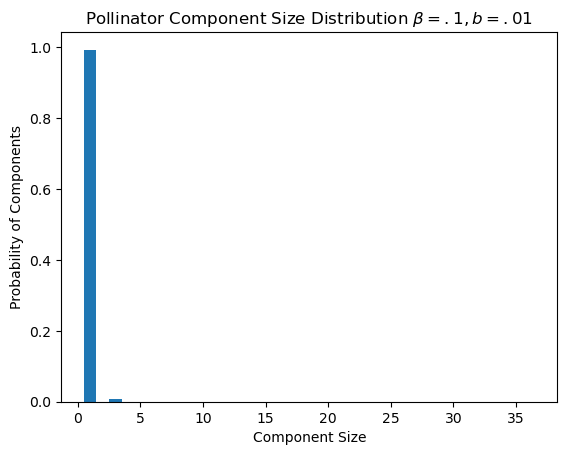

In [119]:
# Get final component distribution
components = [c for c in nx.connected_components(test.g)]
component_lengths = [len(c) for c in components]
# Unique component lengths
counts, bins = np.histogram(component_lengths,bins=range(1,max(component_lengths)))
plt.bar(bins[:-1],counts/sum(counts),width=1)
plt.xlabel('Component Size')
plt.ylabel('Probability of Components')
plt.title(r'Pollinator Component Size Distribution $\beta=.1,b=.01$')
plt.savefig('pollinator_1_1_component_dist.pdf')
plt.show()

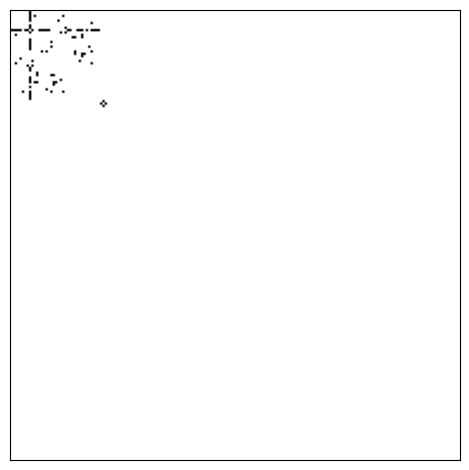

In [120]:
target_A = nx.adjacency_matrix(complex0_g).toarray()
plt.imshow(target_A,cmap='binary')
plt.xticks([],[])
plt.yticks([],[])
# plt.title('Target Adjacency Matrix')
plt.tight_layout()
plt.savefig('pollinator_1_1_adjacency_matrix.pdf')
plt.show()

In [121]:
reference_g = nx.configuration_model(np.array(target_network.degree())[:,1])
components = [c for c in nx.connected_components(reference_g)]
components = sorted(components,key=len,reverse=True)
# Get the order of the nodes
order = []
for c in components:
    order += list(c)
# Relabel the nodes
reference_A = nx.adjacency_matrix(reference_g).toarray()
reference_A = reference_A[order,:][:,order]
reference_g = nx.from_numpy_array(reference_A)

In [122]:
distances = {
    'Jaccard':                 netrd.distance.JaccardDistance(),
    'Hamming':                 netrd.distance.Hamming(),
    'HammingIpsenMikhailov':   netrd.distance.HammingIpsenMikhailov(),
    'Frobenius':               netrd.distance.Frobenius(),
    'PolynomialDissimilarity': netrd.distance.PolynomialDissimilarity(),
    'DegreeDivergence':        netrd.distance.DegreeDivergence(),
    'PortraitDivergence':      netrd.distance.PortraitDivergence(),
    'QuantumJSD':              netrd.distance.QuantumJSD(),
    'CommunicabilityJSD':      netrd.distance.CommunicabilityJSD(),
    'GraphDiffusion':          netrd.distance.GraphDiffusion(),
    # 'ResistancePerturbation':  netrd.distance.ResistancePerturbation(),
    'NetLSD':                  netrd.distance.NetLSD(),
    'IpsenMikhailov':          netrd.distance.IpsenMikhailov(),
    # 'NonBacktrackingSpectral': netrd.distance.NonBacktrackingSpectral(),
    'DistributionalNBD':       netrd.distance.DistributionalNBD(),
    # 'DMeasure':                netrd.distance.DMeasure(),
    'DeltaCon':                netrd.distance.DeltaCon(),
    'NetSimile':               netrd.distance.NetSimile()}

In [123]:
# dictionary to store the outputs
dists = {}

# loop over all the reconstruction techniques
for d_lab, d_i in distances.items():
    dists[d_lab] = d_i.dist(complex0_g,target_network)

/home/glover.co/miniconda3/envs/gt/lib/python3.12/site-packages/netrd/utilities/graph.py:118: RuntimeWarning: Coercing weighted graph to unweighted.
  warnings.warn("Coercing weighted graph to unweighted.", RuntimeWarning)


In [124]:
ref_dists = {}

# loop over all the reconstruction techniques
for d_lab, d_i in distances.items():
    ref_dists[d_lab] = d_i.dist(reference_g,target_network)

/home/glover.co/miniconda3/envs/gt/lib/python3.12/site-packages/netrd/distance/graph_diffusion.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  diffs[kt] = (diff ** 2).sum()


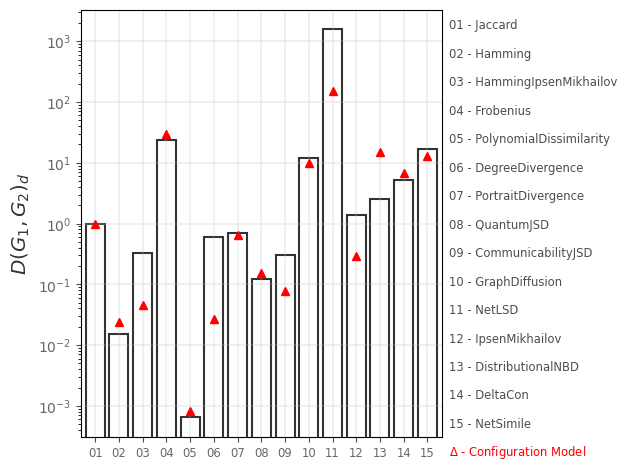

In [125]:
fig, ax = plt.subplots()
ax.bar(x=list(range(len(dists))), height=list(dists.values()), fc='w', ec='.2', lw=1.5)
ax.set_xticks(list(range(len(dists))))
ax.set_xticklabels(["%02i"%(i+1) for i in list(range(len(dists)))],fontsize='small')
ax.set_xlim(-0.6,len(distances)-0.4)
ax.set_yscale('log')
ax.set_ylabel(r'$D(G_1, G_2)_d$', fontsize='x-large', color='.2')
ax.tick_params(labelbottom=True, bottom=True, labelleft=True, left=True, labelcolor='.4', color='.3')
ax.grid(linewidth=1.25,color='.75',alpha=0.25)
for i, title_i in enumerate(list(distances.keys()) + ['Reference']):
    lab_i = "%02i - %s"%(i+1,title_i)
    if i == len(distances):
        lab_i = r"$\Delta$ - Configuration Model"
        ax.text(1.02, 1-(i/len(distances))-0.55/len(distances), lab_i, ha='left', va='center',
               color='r', transform=ax.transAxes, fontsize='small')
    else:
        ax.text(1.02, 1-(i/len(distances))-0.55/len(distances), lab_i, ha='left', va='center',
               color='.3', transform=ax.transAxes, fontsize='small')
ax.plot(np.arange(15),list(ref_dists.values()),'^',color='red',label='CM')
plt.tight_layout()
plt.savefig('pollinator_1_1_distance_comparison.pdf')
plt.show()

In [132]:
nx.is_isomorphic(g,nx.subgraph(test.g,sorted(nx.connected_components(test.g),key=len,reverse=True)[0]))

True

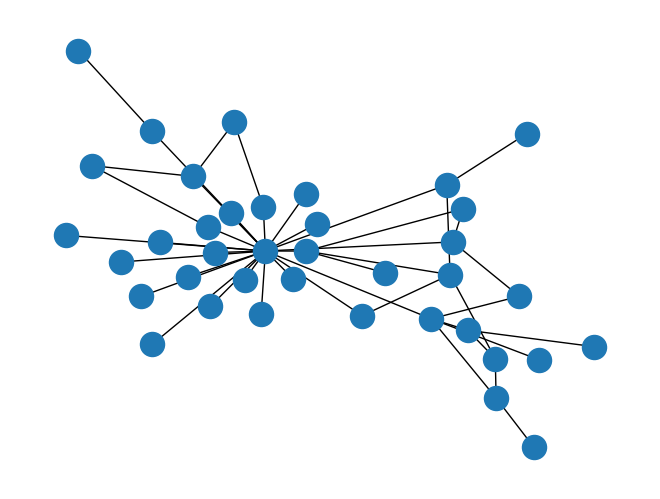

In [130]:
nx.draw(g)

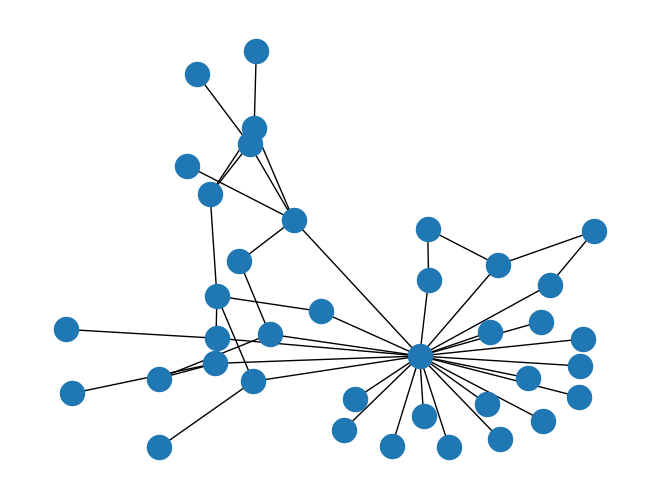

In [131]:
nx.draw(nx.subgraph(test.g,sorted(nx.connected_components(test.g),key=len,reverse=True)[0]))